# Testing the GW toy

In [1]:
import sys
import os
import subprocess

import ray

from astropy.io import fits
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy import integrate

In [2]:
def run_bash(command: str, show: bool = False):
    split_command = command.split(" ")
    output = subprocess.Popen(split_command, stdout=subprocess.PIPE).communicate()
    if show:
        print(output[0].decode("utf-8"))
    else:
        return output[0].decode("utf-8")


def ParseGrbsens(catFileName, Separator="\t", names=None, orient="list"):
    as_dict = pd.read_csv(catFileName, sep=Separator, comment="#", names=names).to_dict(
        orient=orient
    )
    return as_dict


def open_grbsens(filename: str):
    col_names = ["obs_time", "crab_flux", "photon_flux", "energy_flux", "sensitivity"]
    sensi_list = ParseGrbsens(filename, names=col_names, orient="list")

    return sensi_list


def ParseBNS(filename, sep=" ", names=None, orient="index"):
    as_dict = pd.read_csv(
        filename, sep=sep, quotechar='"', comment="#", names=names
    ).to_dict(orient=orient)
    return as_dict


# open grbsens files and create interpolation class:
def get_interpolation(filename: str):
    col_names = ["obs_time", "crab_flux", "photon_flux", "energy_flux", "sensitivity"]
    sensi_list = ParseGrbsens(filename, names=col_names, orient="list")

    # interpolation, x-> obstime, y-> photon_flux
    interpolation = interp1d(sensi_list["obs_time"], sensi_list["photon_flux"])

    return interpolation


def get_interpolation_dict(file_dict: dict):

    for direction, zeniths in file_dict.items():
        for zenith, file in zeniths.items():
            file_dict[direction][zenith] = get_interpolation(
                file_dict[direction][zenith]
            )

    return file_dict


def interpolate_grbsens(x: float, direction: str, zenith: int, interpoations: dict):

    try:
        return interpolations[direction.lower()][zenith](x)
    except KeyError:
        raise AttributeError(f"No {direction} z{zenith} file found!")


def get_energy_limits(zenith: int):

    if zenith not in [20, 40, 60]:
        raise AttributeError("Zenith must be 20, 40, or 60.")
    if zenith == 20:
        lower, upper = 30, 10000
    elif zenith == 40:
        lower, upper = 40, 10000
    else:
        lower, upper = 110, 10000

    return lower, upper


def bns_stats(df: pd.DataFrame = None, input_file: str = None):
    """Print statistics about the data runs"""

    if df is None and input_file is None:
        raise AttributeError("Please proide either a dataframe or an input file.")

    if df:
        n_runs = len(df)
        df_20 = df[df["alt"] == 20]
        df_40 = df[df["alt"] == 40]
        df_60 = df[df["alt"] == 60]

        for data in [df_20, df_40, df_60]:
            print("")


def find_files(catalog_directory: str, ext: str = "fits"):
    fits_files = [
        os.path.abspath(f"{catalog_directory}/{f}")
        for f in os.listdir(os.path.abspath(catalog_directory))
        if f.endswith(f".{ext}")
    ]
    return fits_files


def open_v1_fits(filepath: str):
    try:
        
        grb = {}

        with fits.open(filepath) as hdu_list:

            grb["run"] = hdu_list[0].header["RUN"]
            grb["id"] = hdu_list[0].header["MERGERID"]
            grb["ra"] = hdu_list[0].header["RA"]
            grb["dec"] = hdu_list[0].header["DEC"]
            grb["eiso"] = hdu_list[0].header["EISO"]
            grb["z"] = hdu_list[0].header["REDSHIFT"]
            grb["angle"] = hdu_list[0].header["ANGLE"]

            datalc = hdu_list[3].data
            datatime = hdu_list[2].data
            dataenergy = hdu_list[1].data

            grb["lc"] = datalc.field(0)
            grb["time"] = datatime.field(0)
            grb["energy"] = dataenergy.field(0)
            grb["spec"] = datalc[0]

            return grb

    except FileNotFoundError:
        print(f"Input V1 GRB {filepath} not found.")

# Spectrum
def spectrum(x):
    return (x / 1) ** (-2.1)

In [5]:
def observe_grb(bns_index: int, bns_dict: dict, interpolations, inttime: float, tstart: float = 0, observatory=None, zenith=None):

    # get run and merger ID

    run = bns_dict[bns_index]["run"]
    merger_id = bns_dict[bns_index]["MergerID"]
    if "merger" in merger_id.lower():
        merger_id = merger_id[6:]

    InputGRB = f"GammaCatalogV1.0/{run}_{merger_id}.fits"

    # open grb file
    grb = open_v1_fits(InputGRB)

    # add other bns information:
    #    - later these can be replaces with functions to calculate them
    grb["zenith"] = bns_dict[bns_index]["Mean Altitude"]
    grb["observatory"] = bns_dict[bns_index]["Observatory"]
    if observatory:
        # force observatory if given as input
        grb["observatory"] = observatory.lower().capitalize()
    if zenith:
        # force zenith if given as input
        grb["zenith"] = zenith

    # set the grb to not be seen by default
    grb["seen"] = False
    grb["tend"] = -1
    grb["obstime"] = -1

    # Integral of the spectrum

    lower, upper = get_energy_limits(grb['zenith'])
    
    # print(f"index: {bns_index}, zenith: {zenith}, {lower}GeV-{upper}GeV")

    intl, errl = integrate.quad(lambda x: spectrum(x), lower, upper)  # GeV

    # Interpolation of the flux with time
    flux = interp1d(grb["time"], grb["lc"])

    # start the procedure
    dt = 1
    grb["tstart"] = tstart

    return grb

    for m in range(1, inttime):  # second loop from 1 to max integration time

            t = tstart + m * dt  # tstart = 210, + loop number
            obst = t - tstart  # how much actual observing time has gone by

            fluencen, errorn = integrate.quad(lambda x: flux(x), tstart, t)
            averagefluxn = fluencen * intl / obst  # ph/cm2/s

            photon_flux = interpolate_grbsens(obst, grb["observatory"], grb["zenith"], interpolations)

            if averagefluxn > photon_flux:  # if it is visible:

                if tstart + obst < inttime:  # if starting time < max time, write
                    tend = tstart + obst
                    grb["tend"] = tend
                    grb["obstime"] = obst
                    grb["seen"] = True

                tstart = tstart + obst

                break

    # print(f"Seen: {new_row['seen']}")
    del grb["lc"], grb["time"], grb["energy"], grb["spec"]
    return pd.DataFrame(grb, index=[bns_index])

In [6]:
files = {
    "north": {
        20: "grbsens-5.0sigma_t1s-t16384s_irf-North_z20_0.5h.txt",
        40: "grbsens-5.0sigma_t1s-t16384s_irf-North_z40_0.5h.txt",
        60: "grbsens-5.0sigma_t1s-t16384s_irf-North_z60_0.5h.txt",
    },
    "south": {
        20: "grbsens-5.0sigma_t1s-t16384s_irf-South_z20_0.5h.txt",
        40: "grbsens-5.0sigma_t1s-t16384s_irf-South_z40_0.5h.txt",
        60: "grbsens-5.0sigma_t1s-t16384s_irf-South_z60_0.5h.txt",
    },
}

interpolations = get_interpolation_dict(files)

bns = ParseBNS("BNS-GW-Time_onAxis5deg-original.txt")

In [7]:
grb = observe_grb(5, bns, interpolations, inttime=1000, tstart=252, zenith=40)

In [8]:
grb

,run,id,ra,dec,eiso,z,angle,zenith,observatory,seen,tend,obstime,tstart
5,0020,000430,-25.981,-48.901,2.389455e+49,0.052,4.806,40,South,True,826,574,252


In [11]:
import matplotlib.pyplot as plt

In [15]:
grb = observe_grb(5, bns, interpolations, inttime=1000, tstart=252, zenith=40)

## Testing fitting algs

### Plotting

In [30]:
grbsens = ParseGrbsens("grbsens-5.0sigma_t1s-t16384s_irf-South_z40_0.5h.txt", orient="list", names = ["obs_time", "crab_flux", "photon_flux", "energy_flux", "sensitivity"])

In [31]:
grbsens.keys()

dict_keys(['obs_time', 'crab_flux', 'photon_flux', 'energy_flux', 'sensitivity'])

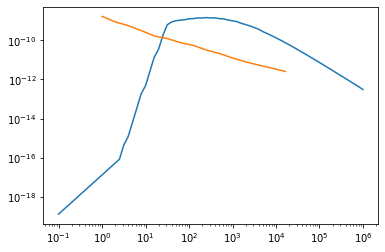

In [33]:
flux = interp1d(grb["time"], grb["lc"])
plt.loglog(grb['time'],grb['lc'])
plt.loglog(grbsens["obs_time"], grbsens["photon_flux"])